In [9]:
library(SummarizedExperiment)
library(VariantAnnotation)
library(Rtsne)
library(ggplot2)
library(gplots)
library(dplyr)
library(irlba)

In [10]:
vcf <- readRDS('~/Dropbox/mixed/original/Map_K10_VBC_CLI.whitelist.noindel.rds')
GT <- geno(vcf)$GT
table(c(GT))


      .     0/0     0/1     0/2     0/3     1/1 
    346 1434753    5506     199       9    5562 

In [11]:
meta <- read.csv('~/Dropbox/mixed/meta/MetaDATAJohnes2.csv', header = TRUE)
rownames(meta) <- meta$SeqID
meta <- meta[colnames(vcf), ]
head(meta)

,SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination
MAP129,MAP129,129,1283,NY,9,tissue,1,2006,NY_1283,Ileum_20cm_from_IC_Valve,4,0
MAP381,MAP381,381,9999,VT,11,environmental,0,2004,VT_9999,environmental,100,0
MAP350,MAP350,350,228,PA,10,tissue,0,2008,PA_228,LymphNode2,6,0
MAP022,MAP022,22,1085,NY,9,fecal,0,2004,NY_1085,fecal,1,0
MAP514,MAP514,514,506,VT,11,fecal,0,2007,VT_506,fecal,1,0
MAP545,MAP545,545,120,VT,11,tissue,0,2007,VT_120,Ileum_20cm_from_IC_Valve,4,0


In [12]:
table(meta$State)


 MN  NY  PA  VT 
106 179  49 191 

In [13]:
GT[GT %in% c('.')] <- '0/0' # missing values
GT[GT%in% c('0/2', '0/3')] <- '0/1'
table(c(GT))
AO <- geno(vcf)$AO # alt read count
DP <- geno(vcf)$DP
is_dp_na <- is.na(DP)
DP[is_dp_na] <- 0
AO[is_dp_na] <- 0
ao_len <- sapply(AO, length)
mult <- which(ao_len > 1)
AO[mult] <- sapply(AO[mult], max)
AO <- matrix(unlist(AO), nrow = nrow(DP), ncol = ncol(DP))
X <- AO / DP # alternative allele ratio
X[is.na(X)] <- 0


    0/0     0/1     1/1 
1435099    5714    5562 

In [14]:
head(X)
dim(X)

,MAP129,MAP381,MAP350,MAP022,MAP514,MAP545,MAP401,MAP727,MAP153,MAP351,...,MAP517,MAP137,MAP944,MAP563,MAP143,MAP439,MAP380,MAP191,MAP006,MAP775
Map_K10_VBC_CLI:48_C/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:288_G/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.02631579,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:356_C/T,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,1,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:752_T/C,1,0.9897959,1,1,1,1,1,0.9939759,1.00000000,1,...,1,1,1,1.00000000,1,1,1,1,0.9834711,1
Map_K10_VBC_CLI:787_A/G,0,0.0000000,0,0,0,0,0,0.0000000,0.02409639,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:798_C/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0


[1] 2755  525

In [15]:
X_selected <- X[,meta$State == 'PA']
meta_selected <- meta[which(meta$State == 'PA'),]
head(X_selected)

,MAP350,MAP351,MAP337,MAP284,MAP344,MAP343,MAP320,MAP291,MAP355,MAP358,...,MAP356,MAP321,MAP353,MAP339,MAP287,MAP357,MAP313,MAP341,MAP347,MAP342
Map_K10_VBC_CLI:48_C/A,0,0,0,0,0.000000000,0,0,0,0,0.00000000,...,0.005235602,0,0.02348993,0,0,0,0,0,0.000000000,0
Map_K10_VBC_CLI:288_G/A,0,0,0,0,0.000000000,0,0,0,0,0.00000000,...,0.000000000,0,0.00000000,0,0,0,0,0,0.000000000,0
Map_K10_VBC_CLI:356_C/T,0,0,0,0,0.000000000,0,0,0,0,0.00000000,...,0.000000000,0,0.00000000,0,0,0,0,0,0.000000000,0
Map_K10_VBC_CLI:752_T/C,1,1,1,1,1.000000000,1,1,1,1,1.00000000,...,0.993670886,1,1.00000000,1,1,1,1,1,1.000000000,1
Map_K10_VBC_CLI:787_A/G,0,0,0,0,0.009090909,0,0,0,0,0.00000000,...,0.000000000,0,0.00000000,0,0,0,0,0,0.008695652,0
Map_K10_VBC_CLI:798_C/A,0,0,0,0,0.000000000,0,0,0,0,0.01333333,...,0.000000000,0,0.00000000,0,0,0,0,0,0.000000000,0


In [16]:
dim(X_selected)

[1] 2755   49

In [17]:
head(meta_selected)

,SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination
MAP350,MAP350,350,228,PA,10,tissue,0,2008,PA_228,LymphNode2,6,0
MAP351,MAP351,351,228,PA,10,tissue,0,2008,PA_228,Ileum_20cm_from_IC_Valve,4,0
MAP337,MAP337,337,49,PA,10,tissue,0,2006,PA_49,Ileum_20cm_from_IC_Valve,4,1
MAP284,MAP284,284,51,PA,10,fecal,0,2004,PA_51,fecal,1,0
MAP344,MAP344,344,9999,PA,10,environmental,0,2006,PA_9999,environmental,100,0
MAP343,MAP343,343,131,PA,10,fecal,0,2006,PA_131,fecal,1,0


In [18]:
GT_freq <- do.call('rbind', lapply(
    1:nrow(GT), 
    function(i) GT[i, ] %>% factor(c('0/0', '0/1', '1/1'), labels = c('AA', 'AB', 'BB')) %>% table()
)) %>% 
    as.data.frame() %>%
    mutate(snp_id = rownames(GT)) %>%
    filter(!(AB == 1 & BB == 0)) %>%
    filter(!(AB == 0 & BB == 1)) %>%
    filter(!(AA == 0 & AB == 0)) %>% 
    arrange(AB) %>% 
    print()
# GT_freq has filtered out singletons

     AA  AB  BB                      snp_id
1   523   0   2    Map_K10_VBC_CLI:6008_C/T
2   523   0   2    Map_K10_VBC_CLI:9890_C/T
3   523   0   2   Map_K10_VBC_CLI:10583_G/A
4   518   0   7   Map_K10_VBC_CLI:16181_A/G
5   522   0   3   Map_K10_VBC_CLI:23889_T/C
6   523   0   2   Map_K10_VBC_CLI:28335_G/A
7   519   0   6   Map_K10_VBC_CLI:44054_G/T
8   515   0  10   Map_K10_VBC_CLI:46975_T/C
9   523   0   2   Map_K10_VBC_CLI:49215_A/G
10  517   0   8   Map_K10_VBC_CLI:53592_C/T
11  519   0   6   Map_K10_VBC_CLI:60682_C/T
12  521   0   4   Map_K10_VBC_CLI:71014_A/G
13  523   0   2   Map_K10_VBC_CLI:71631_G/A
14   17   0 508   Map_K10_VBC_CLI:73211_T/C
15  523   0   2   Map_K10_VBC_CLI:77046_G/T
16  515   0  10   Map_K10_VBC_CLI:78045_C/T
17  521   0   4   Map_K10_VBC_CLI:91027_C/T
18  521   0   4   Map_K10_VBC_CLI:99927_A/G
19  515   0  10  Map_K10_VBC_CLI:103242_A/G
20  522   0   3  Map_K10_VBC_CLI:118442_T/A
21  523   0   2  Map_K10_VBC_CLI:120560_C/T
22  523   0   2  Map_K10_VBC_CLI

In [19]:
head(GT_freq)

AA,AB,BB,snp_id
523,0,2,Map_K10_VBC_CLI:6008_C/T
523,0,2,Map_K10_VBC_CLI:9890_C/T
523,0,2,Map_K10_VBC_CLI:10583_G/A
518,0,7,Map_K10_VBC_CLI:16181_A/G
522,0,3,Map_K10_VBC_CLI:23889_T/C
523,0,2,Map_K10_VBC_CLI:28335_G/A


In [20]:
X_no_orphan <- X_selected[GT_freq$snp_id, ]
head(X_no_orphan)
dim(X_no_orphan)

,MAP350,MAP351,MAP337,MAP284,MAP344,MAP343,MAP320,MAP291,MAP355,MAP358,...,MAP356,MAP321,MAP353,MAP339,MAP287,MAP357,MAP313,MAP341,MAP347,MAP342
Map_K10_VBC_CLI:6008_C/T,0.000000000,0,0.000000000,0.005154639,0,0.00000000,0,0.006756757,0,0,...,0.004694836,0,0.003690037,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:9890_C/T,0.000000000,0,0.000000000,0.000000000,0,0.00000000,0,0.007751938,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:10583_G/A,0.000000000,0,0.005181347,0.000000000,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,1,0,0.00000000,0
Map_K10_VBC_CLI:16181_A/G,0.009174312,0,0.000000000,0.003759398,0,0.00462963,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:23889_T/C,0.000000000,0,0.000000000,0.007142857,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:28335_G/A,0.000000000,0,0.000000000,0.000000000,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.01754386,0


[1] 485  49

In [25]:
X_no_orphan <- X_no_orphan[which(rowSums(X_no_orphan) != 0),] # remove snps without any samples
dim(X_no_orphan)
head(X_no_orphan)

[1] 459  49

,MAP350,MAP351,MAP337,MAP284,MAP344,MAP343,MAP320,MAP291,MAP355,MAP358,...,MAP356,MAP321,MAP353,MAP339,MAP287,MAP357,MAP313,MAP341,MAP347,MAP342
Map_K10_VBC_CLI:6008_C/T,0.000000000,0,0.000000000,0.005154639,0,0.00000000,0,0.006756757,0,0,...,0.004694836,0,0.003690037,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:9890_C/T,0.000000000,0,0.000000000,0.000000000,0,0.00000000,0,0.007751938,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:10583_G/A,0.000000000,0,0.005181347,0.000000000,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,1,0,0.00000000,0
Map_K10_VBC_CLI:16181_A/G,0.009174312,0,0.000000000,0.003759398,0,0.00462963,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:23889_T/C,0.000000000,0,0.000000000,0.007142857,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.00000000,0
Map_K10_VBC_CLI:28335_G/A,0.000000000,0,0.000000000,0.000000000,0,0.00000000,0,0.000000000,0,0,...,0.000000000,0,0.000000000,0,0,0,0,0,0.01754386,0


In [33]:
set.seed(1)
u <- irlba(X_no_orphan, nu = 1, nv = 4)$v
y_tsne <- Rtsne(u, check_duplicates = FALSE, perplexity = 10)$Y

In [34]:
d <- data.frame(
    x = y_tsne[, 1], 
    y = y_tsne[, 2],
    cow_id = meta_selected$CowID,
    type_1 = meta_selected$Type %>% factor(),
    type_2 = meta_selected$Type2 %>% factor(),
    farm = meta_selected$Farm %>% factor(),
    contamination = meta_selected$Contamination %>% factor(),
    date = meta_selected$Date %>% factor(),
    state = meta_selected$State %>% factor(),
    mix = meta_selected$Mix %>% factor()
)
head(d)

x,y,cow_id,type_1,type_2,farm,contamination,date,state,mix
0.194241,5.816456,228,tissue,LymphNode2,10,0,2008,PA,0
-1.729482,6.495571,228,tissue,Ileum_20cm_from_IC_Valve,10,0,2008,PA,0
32.228836,-14.141086,49,tissue,Ileum_20cm_from_IC_Valve,10,1,2006,PA,0
-23.939030,24.796808,51,fecal,fecal,10,0,2004,PA,0
19.587131,-1.762517,9999,environmental,environmental,10,0,2006,PA,0
19.076608,-4.211920,131,fecal,fecal,10,0,2006,PA,0


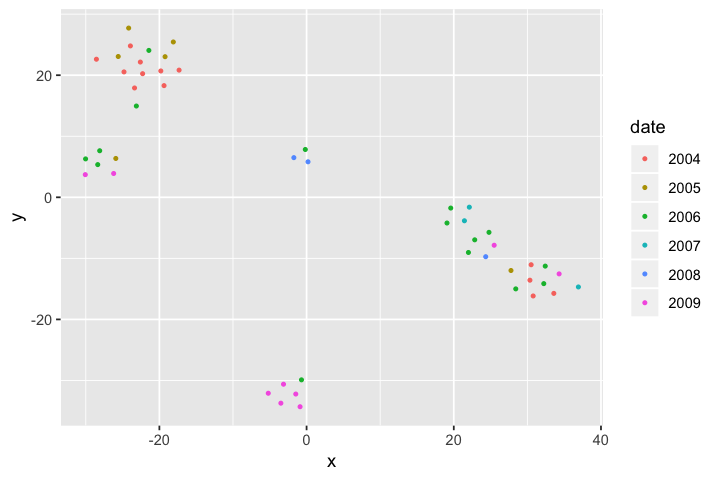

In [35]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = date)) + 
    geom_point(size = 0.75) 

In [36]:
w <- rowSums(X_no_orphan > 0.1 & X_no_orphan < 0.9)
table(w)

w
  0   1   2   3   4   5   6   7  12  17  23  26  35  44 
386  40  14   6   2   1   1   1   2   1   1   1   1   2 

In [37]:
d <- data.frame(
    x = y_tsne[, 1], 
    y = y_tsne[, 2],
    n_heterozygous = (X_no_orphan > 0.1 & X_no_orphan < 0.9) %>% colSums(),
    n_heterozygous_weight = ((X_no_orphan > 0.1 & X_no_orphan < 0.9) * (1 / (w + 1))) %>% colSums()
)
head(d)

,x,y,n_heterozygous,n_heterozygous_weight
MAP350,0.194241,5.816456,6,0.4287037
MAP351,-1.729482,6.495571,8,1.0398148
MAP337,32.228836,-14.141086,6,0.5722222
MAP284,-23.939030,24.796808,4,0.1370370
MAP344,19.587131,-1.762517,10,2.8817460
MAP343,19.076608,-4.211920,6,0.6787037


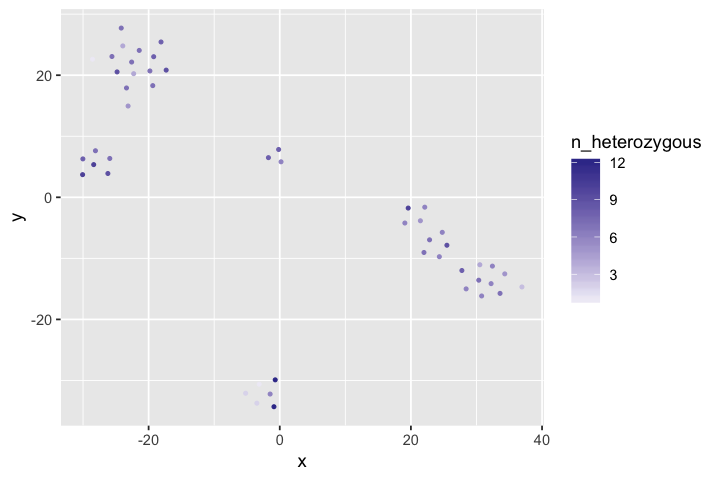

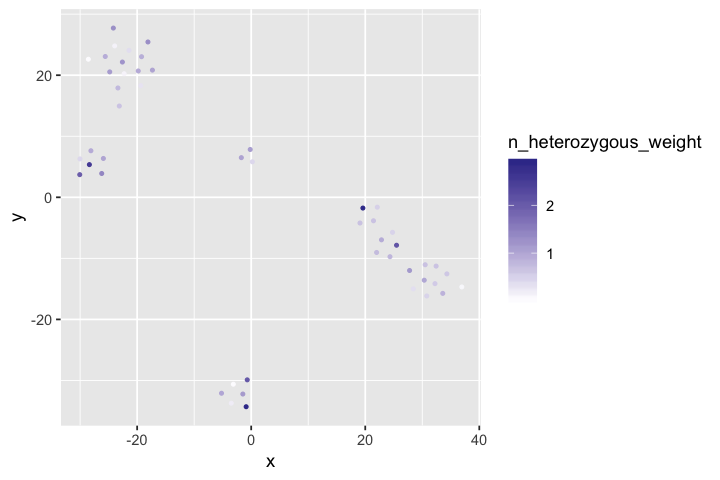

In [38]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = n_heterozygous)) + 
    geom_point(size = 0.75) +
    scale_colour_gradient2()
d %>% 
    ggplot(aes(x = x, y = y, color = n_heterozygous_weight)) + 
    geom_point(size = 0.75) +
    scale_colour_gradient2()